# Monte Carlo simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# --- Probability Distributions ---

# Fan life distribution (in hours)
fan_life_hours = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
fan_life_probs = [0.10, 0.13, 0.25, 0.13, 0.09, 0.12, 0.02, 0.06, 0.05, 0.05]

# Technician arrival time (in minutes)
arrival_times = [20, 30, 45]
arrival_probs = [0.60, 0.30, 0.10]



# Cost Constraints

In [2]:
# --- Cost Parameters ---

downtime_cost_per_min = 10           # $ per minute
fan_replacement_cost = 32            # $ per fan
technician_hourly_rate = 30          # $ per hour
replacement_times = {1: 20, 2: 30, 3: 40}  # Time to replace fans (in minutes)



In [3]:
# --- Helper Functions ---

def simulate_fan_life():
    """Randomly generate fan operational life based on probability distribution."""
    return np.random.choice(fan_life_hours, p=fan_life_probs)

def simulate_technician_arrival():
    """Randomly generate technician arrival delay."""
    return np.random.choice(arrival_times, p=arrival_probs)



# Current Policy

In [4]:
# --- Policy Simulations ---

def simulate_individual_policy():
    """Simulate replacing one failed fan at a time until 45 replacements are completed."""
    total_cost = 0
    fan_lifetimes = [simulate_fan_life() for _ in range(3)]
    replacements = 0

    while replacements < 45:
        # Get time until next fan fails
        time_to_fail = min(fan_lifetimes)
        failed_index = fan_lifetimes.index(time_to_fail)

        # Downtime calculation
        arrival_delay = simulate_technician_arrival()
        downtime = arrival_delay + replacement_times[1]

        # Cost calculation
        cost = (
            downtime * downtime_cost_per_min +
            fan_replacement_cost +
            technician_hourly_rate * (replacement_times[1] / 60)
        )
        total_cost += cost
        replacements += 1

        # Update fan lives
        fan_lifetimes = [life - time_to_fail for life in fan_lifetimes]
        fan_lifetimes[failed_index] = simulate_fan_life()

    return total_cost



# Proposed Policy

In [5]:
def simulate_bulk_policy():
    """Simulate replacing all 3 fans together whenever one fails, until 45 replacements are done."""
    total_cost = 0
    fan_lifetimes = [simulate_fan_life() for _ in range(3)]
    replacements = 0

    while replacements < 45:
        time_to_fail = min(fan_lifetimes)

        arrival_delay = simulate_technician_arrival()
        downtime = arrival_delay + replacement_times[3]

        cost = (
            downtime * downtime_cost_per_min +
            3 * fan_replacement_cost +
            technician_hourly_rate * (replacement_times[3] / 60)
        )
        total_cost += cost
        replacements += 3

        # Reset all fan lifetimes
        fan_lifetimes = [simulate_fan_life() for _ in range(3)]

    return total_cost



# Run Monte Carlo Stimulation

In [6]:
# --- Monte Carlo Simulation ---

def monte_carlo_simulation(trials=1000):
    individual_costs = [simulate_individual_policy() for _ in range(trials)]
    bulk_costs = [simulate_bulk_policy() for _ in range(trials)]

    results = {
        "individual_mean": np.mean(individual_costs),
        "individual_std": np.std(individual_costs),
        "bulk_mean": np.mean(bulk_costs),
        "bulk_std": np.std(bulk_costs),
        "individual_costs": individual_costs,
        "bulk_costs": bulk_costs
    }
    return results

# --- Run the Simulation ---

results = monte_carlo_simulation(trials=1000)

# --- Print Summary ---

print("---- Simulation Results for 45 Fan Replacements ----")
print(f"💡 Individual Replacement Policy:")
print(f"   Average Cost: ${results['individual_mean']:.2f}")
print(f"   Std Deviation: ±${results['individual_std']:.2f}")
print()
print(f"🛠  Bulk Replacement Policy:")
print(f"   Average Cost: ${results['bulk_mean']:.2f}")
print(f"   Std Deviation: ±${results['bulk_std']:.2f}")



---- Simulation Results for 45 Fan Replacements ----
💡 Individual Replacement Policy:
   Average Cost: $22366.90
   Std Deviation: ±$527.17

🛠  Bulk Replacement Policy:
   Average Cost: $11574.40
   Std Deviation: ±$306.90


# Visualization

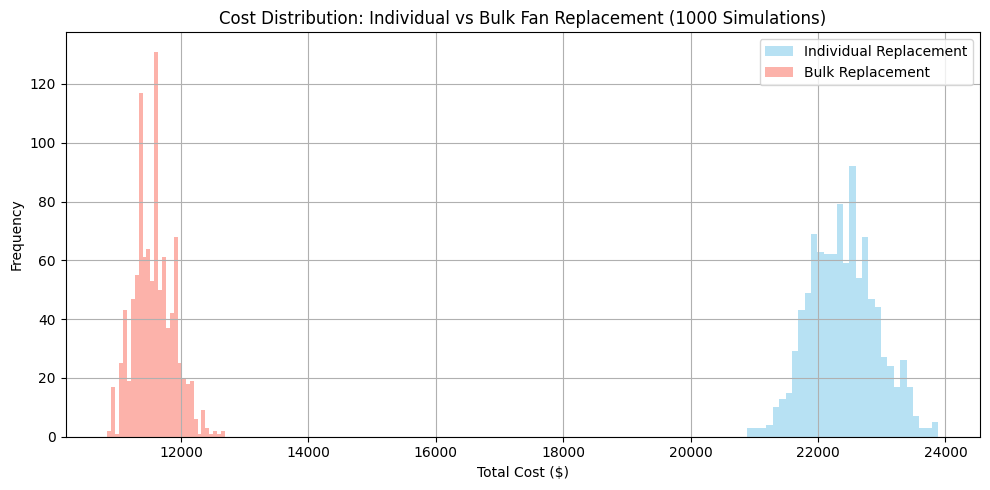

In [7]:
# --- Plot the Cost Distribution ---

plt.figure(figsize=(10, 5))
plt.hist(results["individual_costs"], bins=30, alpha=0.6, label='Individual Replacement', color='skyblue')
plt.hist(results["bulk_costs"], bins=30, alpha=0.6, label='Bulk Replacement', color='salmon')
plt.title("Cost Distribution: Individual vs Bulk Fan Replacement (1000 Simulations)")
plt.xlabel("Total Cost ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

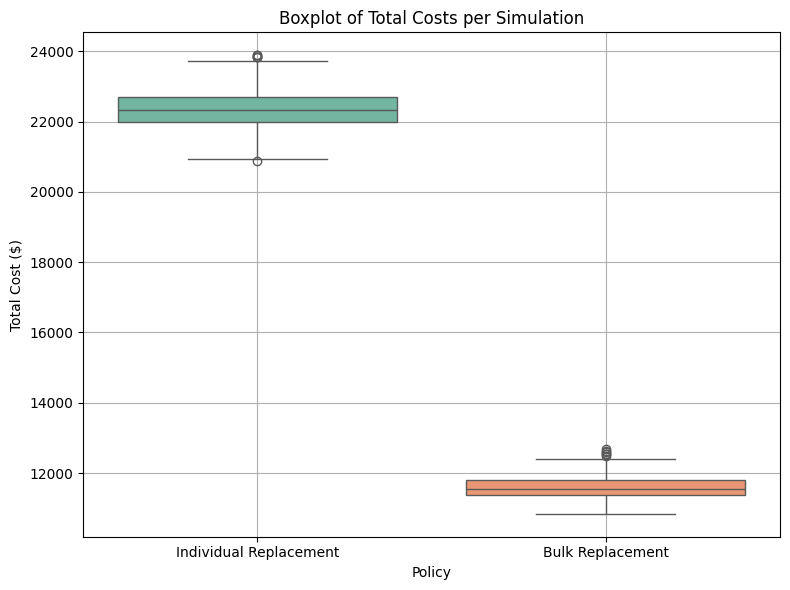

In [8]:
import seaborn as sns
import pandas as pd
# Create a DataFrame for easier plotting
df_results = pd.DataFrame({
    "Individual Replacement": results["individual_costs"],
    "Bulk Replacement": results["bulk_costs"]
})

# Melt for seaborn
df_melted = df_results.melt(var_name="Policy", value_name="Total Cost")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted, x="Policy", y="Total Cost", hue="Policy", palette="Set2", legend=False)
plt.title("Boxplot of Total Costs per Simulation")
plt.ylabel("Total Cost ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


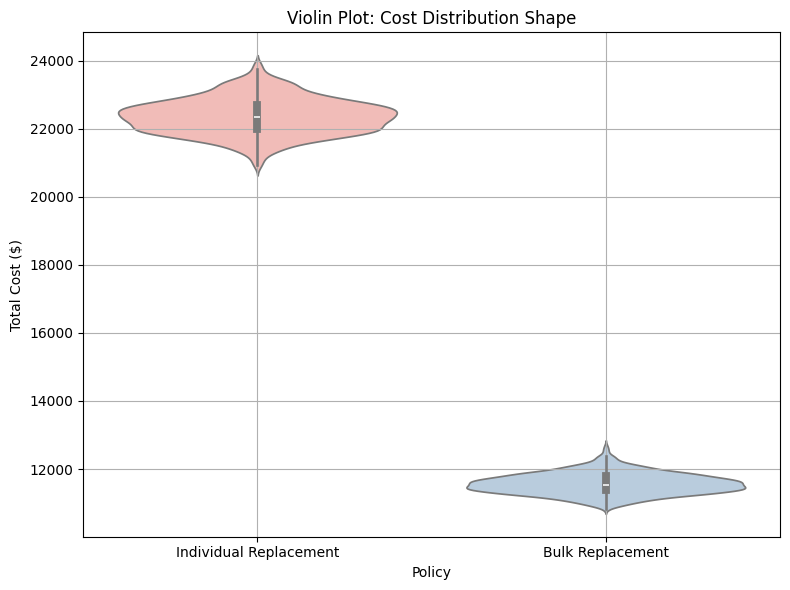

In [9]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_melted, x="Policy", y="Total Cost", hue="Policy", palette="Pastel1", legend=False)
plt.title("Violin Plot: Cost Distribution Shape")
plt.ylabel("Total Cost ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

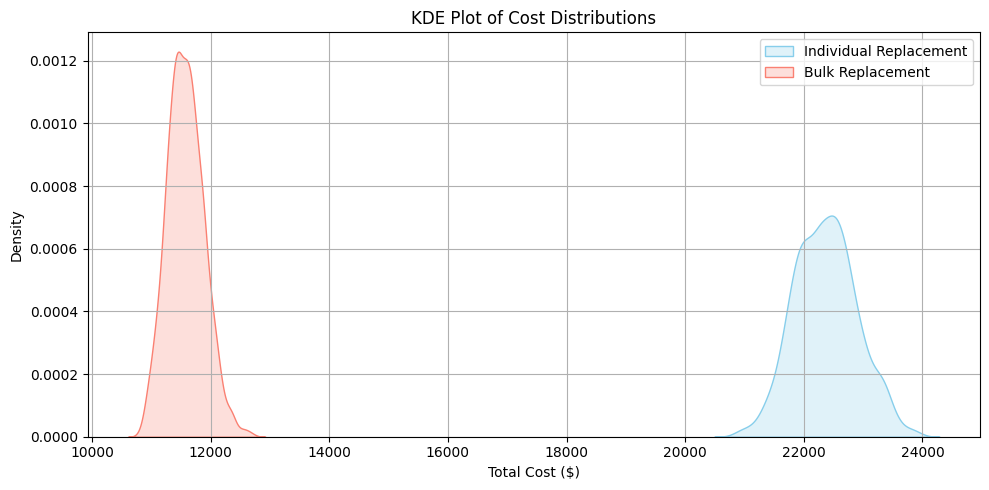

In [10]:
plt.figure(figsize=(10, 5))
sns.kdeplot(results["individual_costs"], label="Individual Replacement", fill=True, color="skyblue")
sns.kdeplot(results["bulk_costs"], label="Bulk Replacement", fill=True, color="salmon")
plt.title("KDE Plot of Cost Distributions")
plt.xlabel("Total Cost ($)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary Stat

In [11]:
summary_stats = pd.DataFrame({
    "Policy": ["Individual", "Bulk"],
    "Mean Cost": [results["individual_mean"], results["bulk_mean"]],
    "Std Dev": [results["individual_std"], results["bulk_std"]],
    "Min Cost": [min(results["individual_costs"]), min(results["bulk_costs"])],
    "Max Cost": [max(results["individual_costs"]), max(results["bulk_costs"])]
})

print(summary_stats.round(2))

       Policy  Mean Cost  Std Dev  Min Cost  Max Cost
0  Individual    22366.9   527.17   20890.0   23890.0
1        Bulk    11574.4   306.90   10840.0   12690.0


# The End